Extract feature from PSD 


Note that I also draw the final ROC curve in this file

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../../")
from pathlib import Path
root = Path("../../")

PosixPath('../..')

In [3]:
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm, trange
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
from joblib import Parallel, delayed
%matplotlib inline

In [4]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl
from pyTVDN.psd import butter_bandpass_filter
from tmp_utils import get_ABIC

In [5]:
with open(root/"OtherFils/data_roi_order.txt", "r") as f:
    region_names_raw = f.readlines()
region_names_raw
region_names = [i.strip()[4].title() + i.strip()[6:].title() 
               for i in region_names_raw if len(i.strip())>0];

In [6]:
resDir = root/"results"
dataDir = root/"data"

PosixPath('../../data')

## Load Data

In [7]:
with open(root/"OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [8]:
freq_bds = edict()
freq_bds.delta = [2, 4]
freq_bds.theta = [4, 8]
freq_bds.alpha = [8, 12]
freq_bds.beta = [12, 35]

In [9]:
AD_PSD = load_pkl(dataDir/"PSD_data/AD88_PSD89_all.pkl");
Ctrl_PSD = load_pkl(dataDir/"PSD_data/Ctrl92_PSD89_all.pkl");
# Rm some Ctrl subs to make two grps balanced
AD_PSD_data = 10*np.log10(AD_PSD.PSDs[kpAD==1])
Ctrl_PSD_data = 10*np.log10(Ctrl_PSD.PSDs[kpCtrl==1])
psd_freq = AD_PSD.freqs

# std or not, not
#AD_PSD_data = (AD_PSD_data-AD_PSD_data.mean(axis=-1, keepdims=True))/AD_PSD_data.std(axis=-1, keepdims=True);
#Ctrl_PSD_data = (Ctrl_PSD_data-Ctrl_PSD_data.mean(axis=-1, keepdims=True))/Ctrl_PSD_data.std(axis=-1, keepdims=True);

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. ,
       39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5,
       45. ])

## Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
from scipy.stats import  norm
import statsmodels.api as sm

from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict

import warnings
warnings.filterwarnings('ignore')
def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res


In [16]:
def _extract_bd_power(psd):
    bd_power = edict()
    for key, v in freq_bds.items():
        bd_power[key] = psd[:, np.bitwise_and(psd_freq>=v[0], psd_freq<v[1])].mean(axis=-1)
    bd_power["all"] = psd[:, np.bitwise_and(psd_freq>=1, psd_freq<35)].mean(axis=-1)
    return bd_power

In [17]:
PSD_data = AD_PSD_data

fs_all = []
for sub_ix in range(len(PSD_data)):
    fs = edict()
    
    tmp = _extract_bd_power(PSD_data[sub_ix])
    fs["alpha"] = tmp["alpha"]
    fs["theta"] = tmp["theta"]
    fs["all"] = tmp["all"]

    fs_all.append(fs)

fs_AD = fs_all;

In [18]:
PSD_data = Ctrl_PSD_data

fs_all = []
for sub_ix in range(len(PSD_data)):
    fs = edict()
    
    tmp = _extract_bd_power(PSD_data[sub_ix])
    fs["alpha"] = tmp["alpha"]
    fs["theta"] = tmp["theta"]
    fs["all"] = tmp["all"]

    fs_all.append(fs)

fs_Ctrl = fs_all;

In [19]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fs_AD)), np.zeros(len(fs_Ctrl))])
fsName = ["all"]

XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fs_AD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fs_AD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fs_Ctrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fs_AD])
        cfCtrl = np.array([fs[fName] for fs in fs_Ctrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.05, 0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
print(preFix)

all_l2


### First fit

In [20]:
# The opTuningC will be used throughout
goptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]
print(goptC)

0.4


In [21]:
# fit the first reg
clf_final = LogisticRegression(penalty=penalty, random_state=0, C=goptC)
clf_final.fit(stdXs, Ys)
coefs_final = clf_final.coef_.reshape(-1);

In [22]:
# bootstrap
def _run_fn_boot(i):
    np.random.seed(i)
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    cur_optC = goptC
    #cur_optC = TuningCFn(stdXsBoot, YsBoot, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=cur_optC)
    clf.fit(stdXsBoot, YsBoot)
    paras_boot = clf.coef_.reshape(-1)
    return paras_boot
    
n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    parass_boot = parallel(delayed(_run_fn_boot)(i) 
                   for i in tqdm(range(n_rep)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 505.58it/s]


In [23]:
parass_boot = np.array(parass_boot)
lows, ups = coefs_final-parass_boot.std(axis=0)*1.96, coefs_final+parass_boot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

print(kpidxIdBoot)
xlabs = np.concatenate([fsName[:-1],
                         region_names])
select_fs_idx = kpidxBoot;

[ 0  6  9 13 23 26 32 48 52]


In [24]:
# Pvalue
test_stats_boot = coefs_final/parass_boot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(test_stats_boot)));

In [25]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefs_final[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                      Feature  Parameters      Lower      Upper   Pvalues
0                  L-Bankssts  -6.244e-01 -1.097e+00 -1.513e-01 9.692e-03
1                  L-Fusiform  -6.617e-01 -1.162e+00 -1.613e-01 9.542e-03
2                    L-Insula   6.141e-01  1.283e-01  1.100e+00 1.323e-02
3                   L-Lingual  -5.674e-01 -1.045e+00 -9.014e-02 1.980e-02
4        L-Posteriorcingulate  -8.983e-01 -1.381e+00 -4.155e-01 2.652e-04
5  L-Rostralanteriorcingulate   1.179e+00  7.165e-01  1.641e+00 5.808e-07
6              L-Temporalpole   7.157e-01  1.736e-01  1.258e+00 9.666e-03
7       R-Medialorbitofrontal   8.314e-01  3.660e-01  1.297e+00 4.626e-04
8           R-Parsopercularis   8.390e-01  3.858e-01  1.292e+00 2.851e-04


### Second fit

In [26]:
# select fs
stdXs_selected = stdXs[:, select_fs_idx]
print(stdXs_selected.shape)

goptC2 = TuningCFn(stdXs_selected, Ys, Cs, penalty=penalty)["optC"]
print(goptC2)
def pred_run_fn_sel(trIdxs, testIdxs, curOptC=None):
    """
    This function trains a logistic regression model on the given training indices and predicts probabilities for the test indices.

    Args:
    trIdxs (array-like): Indices of the training data.
    testIdxs (array-like): Indices of the test data.

    Returns:
    eprob (array-like): Predicted probabilities for the test data.
    paras (array-like): Coefficients of the logistic regression model.
    """
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    paras = clf.coef_.reshape(-1)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])

    return eprob, paras, curOptC

(176, 9)
12.8


In [34]:
def get_ABIC(Xs, Ys, C):
    lam = 2/C
    clf_info = LogisticRegression(penalty="l2", random_state=0, C=C);
    clf_info.fit(Xs, Ys)
    eprobs1 = clf_info.predict_proba(Xs)[:, 1];
    logL = np.sum(Ys*np.log(eprobs1) + (1-Ys)*np.log(1-eprobs1));
    
    # effective df
    fXs = np.concatenate([np.ones((Xs.shape[0], 1)), Xs], axis=-1)
    logL_der2 = -fXs.T @ np.diag(eprobs1*(1-eprobs1)) @ fXs;
    logL_der2_ridge = logL_der2 - lam * np.eye(logL_der2.shape[0]);
    dfe = np.diag(logL_der2@np.linalg.inv(logL_der2_ridge)).sum();
    aic = -2*logL + 2*dfe
    bic = -2*logL + np.log(Ys.shape[0])*dfe
    return aic, bic
# get AIC and BIC 
get_ABIC(stdXs_selected, Ys, goptC2)

(189.23195936795767, 219.25540121692438)

In [32]:
loo = LeaveOneOut()
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_sel)(trIdxs, testIdxs) 
                   for trIdxs, testIdxs in tqdm(loo.split(stdXs_selected), total=len(stdXs_selected))
                  )
parass = np.array([ix[1] for ix in res])
eprobs = np.array([ix[0] for ix in res]).squeeze();
loo_auc = roc_auc_score(Ys, eprobs[:, 1])
loo_fpr, loo_tpr, loo_thresholds = roc_curve(Ys, eprobs[:, 1], pos_label=1)
print(loo_auc)

resROC = {"fpr":loo_fpr, "tpr":loo_tpr, "AUC":loo_auc}
save_pkl(resDir/f"PSD_ROCcurve_reg2.pkl", resROC, is_force=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [02:57<00:00,  1.01s/it]


0.8108212809917356
Save to ../../results/PSD_ROCcurve_reg2.pkl


In [33]:
def pred_run_fn_CV(i, curOptC=None):
    
    np.random.seed(i)
    nobs = stdXs_selected.shape[0]
    
    testIdxs = np.random.choice(nobs, int(nobs/5), False)
    trIdxs = np.delete(np.arange(nobs), testIdxs)
    
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])
    cur_auc = roc_auc_score(Ys[testIdxs], eprob[:, 1])
    return cur_auc, curOptC

n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_CV)(i, goptC2) 
                   for i in tqdm(range(n_rep)))

aucs = [ix[0] for ix in res]
auc_m = np.mean(aucs)
auc_std = np.std(aucs)
print(f"The mean of AUC under 1000 repetitions is {auc_m:.3f} and the standard deviation is {auc_std:.3f}, "
      f"the 95% CI is ({np.quantile(aucs, 0.025):.3f}, {np.quantile(aucs, 0.975):.3f}).")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 662.10it/s]


The mean of AUC under 1000 repetitions is 0.814 and the standard deviation is 0.068, the 95% CI is (0.673, 0.937).


## All results

In [45]:
rocAll = {}
rocAll['TVDN'] = load_pkl(resDir/"TVDN_ROCcurve_reg2_r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2.pkl")
rocAll['TVDMD'] = load_pkl(resDir/"TVDMD_ROCcurve_reg2_r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2.pkl")
rocAll['ND'] = load_pkl(resDir/"ND_ROCcurve_reg2_r_tQ_tL_wU.pkl")
rocAll['DMD'] = load_pkl(resDir/"DMD_ROCcurve_reg2_r_tQ_tL_wU.pkl")
rocAll['STA'] = load_pkl(resDir/"TASA_ROCcurve_reg2.pkl")
#rocAll['PSD'] = load_pkl(resDir/"PSD_ROCcurve_reg2.pkl");

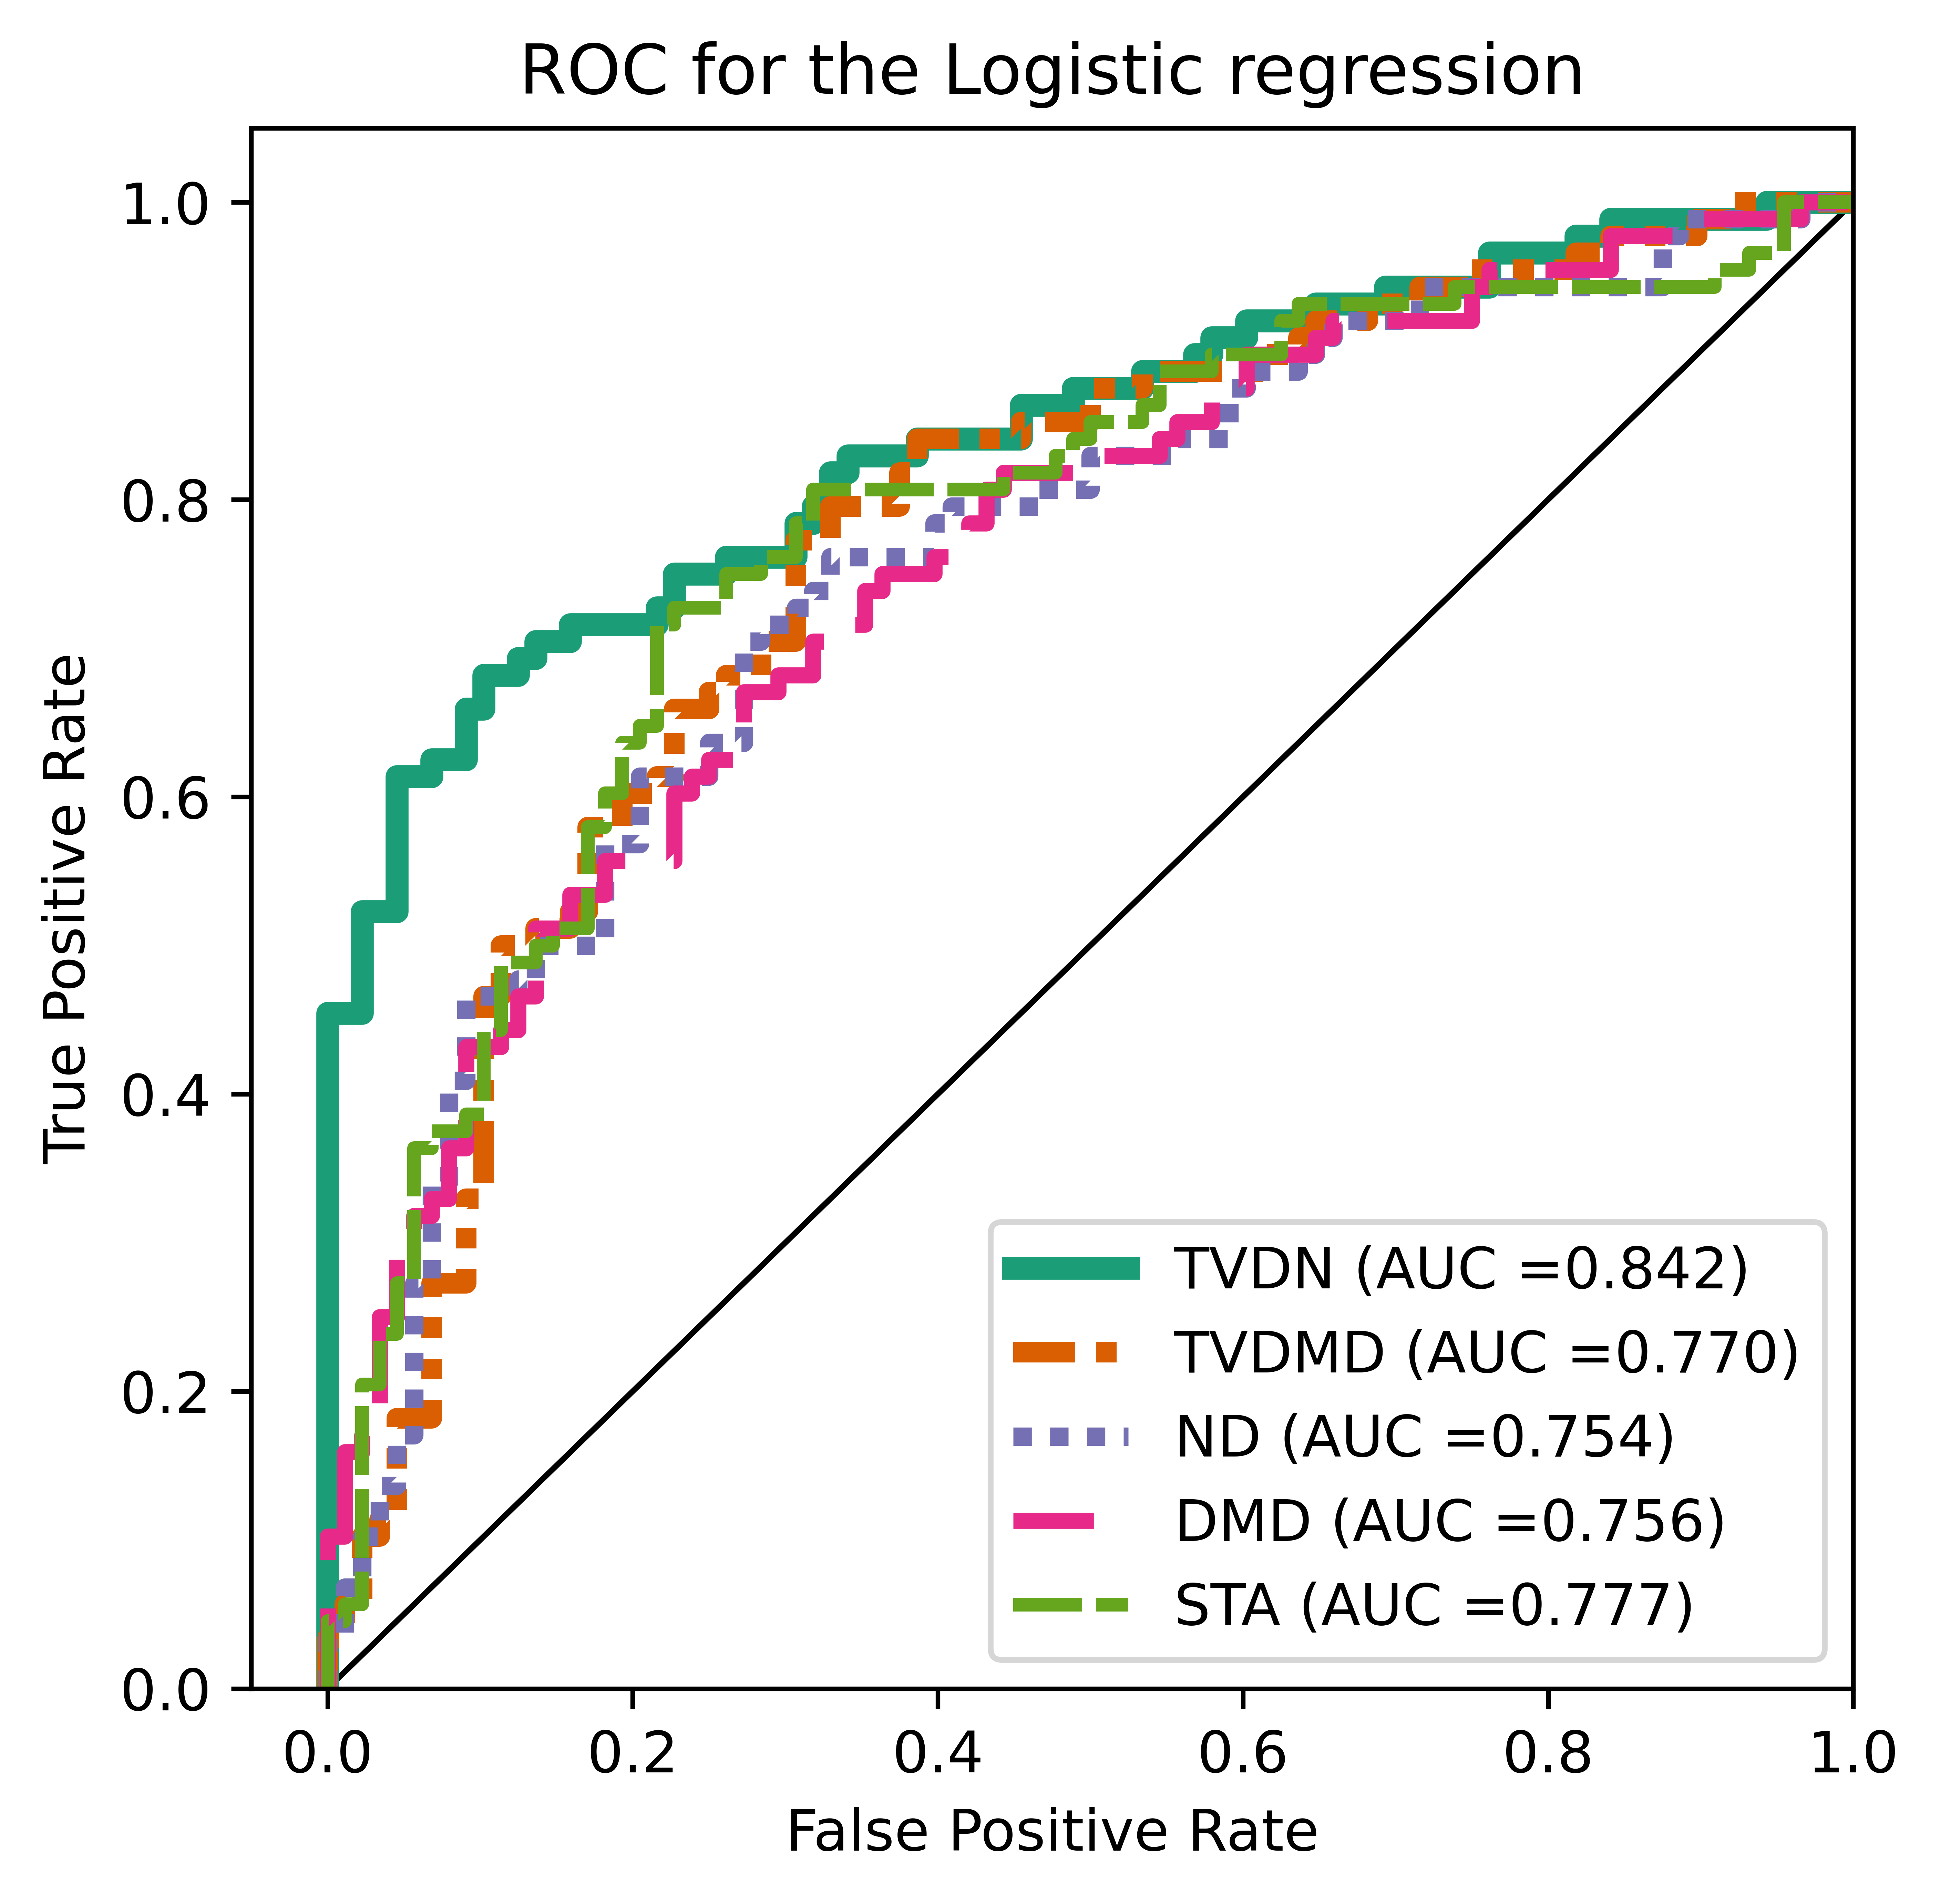

In [46]:
lss = [
     ("line", "-"),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('densely dashed',        (0, (5, 1))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
]
#cols = sns.color_palette(None, len(rocAll))
#cols =["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33",]
cols = [ "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
markers = ["o", "h", "s", "*", "^", "+"]
lws = np.linspace(4, 2, 6)
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="-")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
flag = 0
for key, v in rocAll.items():
    plt.plot(v["fpr"], v["tpr"], label=f"{key} (AUC ={v['AUC']:.3f})", 
             lw=lws[flag], color=cols[flag], linestyle=lss[flag][1])#, marker=markers[flag])
    flag += 1
plt.legend(loc="lower right")
plt.savefig(f"../../plots/double_reg_rocAll_noPSD_R1.jpg", bbox_inches='tight')

In [52]:
n_rep = 10000
mvs = [0.843, 0.774, 0.765, 0.762, 0.788, 0.814]
sds = [0.064, 0.071, 0.074, 0.074, 0.071, 0.068]
mv = 0.843
for sd, mv in zip(sds, mvs):
    se = sd/np.sqrt(n_rep)
    print([np.round(mv-1.96*se, 3), np.round(mv+1.96*se, 3)])

[0.842, 0.844]
[0.773, 0.775]
[0.764, 0.766]
[0.761, 0.763]
[0.787, 0.789]
[0.813, 0.815]
